In [1]:
import sys
import math
import json
import os
from collections import Counter
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import plotly.graph_objects as go
from microbert.model import MicroBERTForClassification
from microbert.tokenizer import WordTokenizer
from microbert.utils import IMDBDataloader, get_attention_scores, plot_parallel, plot_results, save_model, load_model
from hiq.vis import print_model

In [2]:
NUM_EPOCHS = 100
BATCH_SIZE = 32
MAX_SEQ_LEN = 128
LEARNING_RATE = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if trained model already exists
home_dir = os.path.expanduser('~')
model_save_dir = os.path.join(home_dir, '.microbert_model')

In [3]:

data = None
with open('imdb_train.json') as f:
    data = [json.loads(l) for l in f.readlines()]

vocab = set()
for d in data:
    vocab |= set([w.lower() for w in d['text']])

test_data = None
with open('imdb_test.json') as f:
   test_data = [json.loads(l) for l in f.readlines()]

def encode_label(label):
    if label == 'pos':
        return 1
    elif label == 'neg':
        return 0
    raise Exception(f'Unknown Label: {label}!')


tokenizer = WordTokenizer(vocab=vocab, max_seq_len=MAX_SEQ_LEN)
dataloader = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=BATCH_SIZE)

Val Label Encoding: 100%|██████████| 5000/5000 [00:00<00:00, 6204591.72it/s]


In [4]:
n_layers, n_embed, n_heads = 1, 3, 1
bert = MicroBERTForClassification(
    vocab_size=len(tokenizer.vocab),
    n_layers=n_layers,
    n_heads=n_heads,
    n_embed=n_embed,
    max_seq_len=MAX_SEQ_LEN,
    n_classes=2
).to(device)

print_model(bert)


🌳 MicroBERTForClassification<all params:755480>
├── MicroBERT(micro_bert)
│   ├── BertEmbeddings(embedding)
│   │   ├── Embedding(word_embeddings)|weight[251641,3]
│   │   ├── Embedding(pos_embeddings)|weight[128,3]
│   │   └── LayerNorm(layer_norm)|weight[3]|bias[3]
│   ├── BertEncoder(encoder)
│   │   └── ModuleList(layers)
│   │       └── BertLayer(0)
│   │           ├── 💠 ]8;id=21224;/home/wukong/miniconda3/envs/genaibook/lib/python3.10/site-packages/torch/nn/modules/normalization.py\LayerNorm]8;;\]8;id=811268;/home/wukong/miniconda3/envs/genaibook/lib/python3.10/site-packages/torch/nn/modules/normalization.py\(layer_norm1,layer_norm2)<🦜:6x2>|]8;;\]8;id=250392;/home/wukong/miniconda3/envs/genaibook/lib/python3.10/site-packages/torch/nn/modules/normalization.py\weight[3]|]8;;\]8;id=736691;/home/wukong/miniconda3/envs/genaibook/lib/python3.10/site-packages/torch/nn/modules/normalization.py\bias[3]]8;;\
│   │           ├── BertSelfAttention(self_attention)
│   │           │   ├── ModuleList(heads)
│   │           │   │   └── BertAttentionHead(0)
│   │           │   │       └── 💠 ]8;id=665292;/home/wukong/miniconda3/envs/genaibook/lib/python3.10/site-packages/torch/nn/modules/linear.py\Linear]8;;\]8;id=619344;/home/wukong/miniconda3/envs/genaibook/lib/python3.10/site-packages/torch/nn/modules/linear.py\(query,key,values)<🦜:12x3>|]8;;\]8;id=229814;/home/wukong/miniconda3/envs/genaibook/lib/python3.10/site-packages/torch/nn/modules/linear.py\weight[3,3]|]8;;\]8;id=532286;/home/wukong/miniconda3/envs/genaibook/lib/python3.10/site-packages/torch/nn/modules/linear.py\bias[3]]8;;\
│   │           │   └── Linear(proj)|weight[3,3]|bias[3]
│   │           └── FeedForward(feed_forward)
│   │               └── Sequential(ffwd)
│   │                   ├── Linear(0)|weight[12,3]|bias[12]
│   │                   └── Linear(2)|weight[3,12]|bias[3]
│   └── BertPooler(pooler)
│       └── Linear(dense)|weight[3,3]|bias[3]
└── Linear(classifier)|weight[2,3]|bias[2]

In [8]:
history = {
    'train_losses': [],
    'val_losses': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}

optimizer = torch.optim.Adam(bert.parameters(), lr=LEARNING_RATE)

for i in range(NUM_EPOCHS):
    print(f'Epoch: {i + 1}')
    train_loss = 0.0
    train_preds = []
    train_labels = []

    bert.train()
    total = dataloader.steps('train')
    the_split = dataloader.get_split('train')
    for step, batch in enumerate(tqdm(the_split, total=total)):
        logits = bert(batch['input_ids'].to(device)) # (B, Seq_Len, 2)
        probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in batch['label_ids']]
        input_logits = logits[:, 0, :].cpu()  # (B, 2)
        target_labels = batch['label_ids'].cpu()  # (B)
        loss = F.cross_entropy(input_logits, target_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0.0
    val_preds = []
    val_labels = []

    bert.eval()
    for step, batch in enumerate(tqdm(dataloader.get_split('val'), total=dataloader.steps('val'))):
        logits = bert(batch['input_ids'].to(device))
        probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        val_preds += pred.detach().tolist()
        val_labels += [l.item() for l in batch['label_ids']]
        loss = F.cross_entropy(logits[:, 0, :].cpu(), batch['label_ids'])
        val_loss += loss.item()

    history['train_losses'].append(train_loss)
    history['val_losses'].append(val_loss)
    history['train_acc'].append(accuracy_score(train_labels, train_preds))
    history['val_acc'].append(accuracy_score(val_labels, val_preds))
    history['train_f1'].append(f1_score(train_labels, train_preds))
    history['val_f1'].append(f1_score(val_labels, val_preds))

    if i % 20 == 0:
        print(f'Epoch {i + 1} - Train Loss: {train_loss / dataloader.steps("train")}, Val Loss: {val_loss / dataloader.steps("val")}')
        print(f'Train Acc: {accuracy_score(train_labels, train_preds)}, Val Acc: {accuracy_score(val_labels, val_preds)}')
        print(f'Train F1: {f1_score(train_labels, train_preds)}, Val F1: {f1_score(val_labels, val_preds)}')

Epoch: 1


100%|██████████| 625/625 [00:01<00:00, 350.15it/s]
157it [00:00, 837.87it/s]                        


Epoch 1 - Train Loss: 0.5110518543720245, Val Loss: 0.637394571915651
Train Acc: 0.75695, Val Acc: 0.665
Train F1: 0.7523562076519437, Val F1: 0.659206510681587
Epoch: 2


100%|██████████| 625/625 [00:01<00:00, 370.33it/s]
157it [00:00, 893.10it/s]                        


Epoch: 3


100%|██████████| 625/625 [00:01<00:00, 364.61it/s]
157it [00:00, 943.38it/s]                          


Epoch: 4


100%|██████████| 625/625 [00:01<00:00, 366.53it/s]
157it [00:00, 871.74it/s]                        


Epoch: 5


100%|██████████| 625/625 [00:01<00:00, 363.40it/s]
157it [00:00, 873.84it/s]                        


Epoch: 6


100%|██████████| 625/625 [00:01<00:00, 320.84it/s]
157it [00:00, 838.68it/s]                        


Epoch: 7


100%|██████████| 625/625 [00:01<00:00, 360.30it/s]
157it [00:00, 846.62it/s]                        


Epoch: 8


100%|██████████| 625/625 [00:01<00:00, 374.34it/s]
157it [00:00, 961.56it/s]                          


Epoch: 9


100%|██████████| 625/625 [00:01<00:00, 389.80it/s]
157it [00:00, 965.79it/s]                        


Epoch: 10


100%|██████████| 625/625 [00:01<00:00, 349.62it/s]
157it [00:00, 851.61it/s]                        


Epoch: 11


100%|██████████| 625/625 [00:01<00:00, 346.04it/s]
157it [00:00, 847.34it/s]                        


Epoch: 12


100%|██████████| 625/625 [00:01<00:00, 360.31it/s]
157it [00:00, 883.79it/s]                        


Epoch: 13


100%|██████████| 625/625 [00:01<00:00, 347.83it/s]
157it [00:00, 860.20it/s]                        


Epoch: 14


100%|██████████| 625/625 [00:01<00:00, 373.31it/s]
157it [00:00, 916.63it/s]                        


Epoch: 15


100%|██████████| 625/625 [00:01<00:00, 353.94it/s]
157it [00:00, 833.87it/s]                        


Epoch: 16


100%|██████████| 625/625 [00:01<00:00, 368.36it/s]
157it [00:00, 893.97it/s]                        


Epoch: 17


100%|██████████| 625/625 [00:01<00:00, 364.56it/s]
157it [00:00, 860.28it/s]                        


Epoch: 18


100%|██████████| 625/625 [00:01<00:00, 372.95it/s]
157it [00:00, 1134.39it/s]                         


Epoch: 19


100%|██████████| 625/625 [00:01<00:00, 376.31it/s]
157it [00:00, 865.41it/s]                        


Epoch: 20


100%|██████████| 625/625 [00:01<00:00, 377.18it/s]
157it [00:00, 864.99it/s]                        


Epoch: 21


100%|██████████| 625/625 [00:01<00:00, 372.74it/s]
157it [00:00, 1011.01it/s]                         


Epoch 21 - Train Loss: 0.4632279164791107, Val Loss: 0.6347890452314646
Train Acc: 0.7889, Val Acc: 0.675
Train F1: 0.7859026369168356, Val F1: 0.6701846965699209
Epoch: 22


100%|██████████| 625/625 [00:01<00:00, 325.05it/s]
157it [00:00, 840.05it/s]                        


Epoch: 23


100%|██████████| 625/625 [00:01<00:00, 347.22it/s]
157it [00:00, 851.26it/s]                        


Epoch: 24


100%|██████████| 625/625 [00:01<00:00, 372.25it/s]
157it [00:00, 735.80it/s]                        


Epoch: 25


100%|██████████| 625/625 [00:01<00:00, 420.64it/s]
157it [00:00, 1112.64it/s]                         


Epoch: 26


100%|██████████| 625/625 [00:01<00:00, 392.34it/s]
157it [00:00, 844.31it/s]                        


Epoch: 27


100%|██████████| 625/625 [00:01<00:00, 326.38it/s]
157it [00:00, 880.91it/s]                        


Epoch: 28


100%|██████████| 625/625 [00:01<00:00, 335.54it/s]
157it [00:00, 867.87it/s]                        


Epoch: 29


100%|██████████| 625/625 [00:01<00:00, 329.98it/s]
157it [00:00, 831.71it/s]                        


Epoch: 30


100%|██████████| 625/625 [00:01<00:00, 361.28it/s]
157it [00:00, 833.86it/s]                        


Epoch: 31


100%|██████████| 625/625 [00:01<00:00, 364.03it/s]
157it [00:00, 868.48it/s]                        


Epoch: 32


100%|██████████| 625/625 [00:01<00:00, 345.08it/s]
157it [00:00, 843.66it/s]                        


Epoch: 33


100%|██████████| 625/625 [00:01<00:00, 369.36it/s]
157it [00:00, 842.09it/s]                        


Epoch: 34


100%|██████████| 625/625 [00:01<00:00, 343.34it/s]
157it [00:00, 868.84it/s]                        


Epoch: 35


100%|██████████| 625/625 [00:01<00:00, 387.54it/s]
157it [00:00, 843.34it/s]                        


Epoch: 36


100%|██████████| 625/625 [00:01<00:00, 427.69it/s]
157it [00:00, 1073.85it/s]                         


Epoch: 37


100%|██████████| 625/625 [00:01<00:00, 381.01it/s]
157it [00:00, 919.60it/s]                        


Epoch: 38


100%|██████████| 625/625 [00:01<00:00, 339.99it/s]
157it [00:00, 883.31it/s]                        


Epoch: 39


100%|██████████| 625/625 [00:01<00:00, 397.74it/s]
157it [00:00, 1010.45it/s]                         


Epoch: 40


100%|██████████| 625/625 [00:01<00:00, 375.81it/s]
157it [00:00, 847.64it/s]                        


Epoch: 41


100%|██████████| 625/625 [00:01<00:00, 353.15it/s]
157it [00:00, 862.07it/s]                        


Epoch 41 - Train Loss: 0.4225197459459305, Val Loss: 0.636601329040833
Train Acc: 0.8148, Val Acc: 0.6854
Train F1: 0.8119987818495583, Val F1: 0.6824146981627296
Epoch: 42


100%|██████████| 625/625 [00:01<00:00, 350.63it/s]
157it [00:00, 1004.72it/s]                         


Epoch: 43


100%|██████████| 625/625 [00:01<00:00, 346.16it/s]
157it [00:00, 866.41it/s]                        


Epoch: 44


100%|██████████| 625/625 [00:01<00:00, 371.00it/s]
157it [00:00, 817.55it/s]                        


Epoch: 45


100%|██████████| 625/625 [00:01<00:00, 362.24it/s]
157it [00:00, 848.02it/s]                        


Epoch: 46


100%|██████████| 625/625 [00:01<00:00, 385.71it/s]
157it [00:00, 943.81it/s]                         


Epoch: 47


100%|██████████| 625/625 [00:01<00:00, 314.60it/s]
157it [00:00, 919.51it/s]                        


Epoch: 48


100%|██████████| 625/625 [00:01<00:00, 403.20it/s]
157it [00:00, 877.66it/s]                        


Epoch: 49


100%|██████████| 625/625 [00:01<00:00, 356.79it/s]
157it [00:00, 827.57it/s]                        


Epoch: 50


100%|██████████| 625/625 [00:01<00:00, 313.88it/s]
157it [00:00, 852.75it/s]                        


Epoch: 51


100%|██████████| 625/625 [00:01<00:00, 335.12it/s]
157it [00:00, 833.84it/s]                        


Epoch: 52


100%|██████████| 625/625 [00:01<00:00, 371.29it/s]
157it [00:00, 847.93it/s]                        


Epoch: 53


100%|██████████| 625/625 [00:01<00:00, 366.82it/s]
157it [00:00, 1073.43it/s]                       


Epoch: 54


100%|██████████| 625/625 [00:01<00:00, 396.76it/s]
157it [00:00, 878.32it/s]                        


Epoch: 55


100%|██████████| 625/625 [00:01<00:00, 370.30it/s]
157it [00:00, 889.16it/s]                        


Epoch: 56


100%|██████████| 625/625 [00:01<00:00, 364.50it/s]
157it [00:00, 885.01it/s]                        


Epoch: 57


100%|██████████| 625/625 [00:01<00:00, 339.26it/s]
157it [00:00, 915.17it/s]                        


Epoch: 58


100%|██████████| 625/625 [00:01<00:00, 350.23it/s]
157it [00:00, 884.45it/s]                        


Epoch: 59


100%|██████████| 625/625 [00:01<00:00, 359.00it/s]
157it [00:00, 884.16it/s]                        


Epoch: 60


100%|██████████| 625/625 [00:01<00:00, 366.21it/s]
157it [00:00, 846.30it/s]                        


Epoch: 61


100%|██████████| 625/625 [00:01<00:00, 339.10it/s]
157it [00:00, 848.54it/s]                        


Epoch 61 - Train Loss: 0.3885057308912277, Val Loss: 0.6387989584069985
Train Acc: 0.83485, Val Acc: 0.6962
Train F1: 0.8330553449583018, Val F1: 0.6960176105663398
Epoch: 62


100%|██████████| 625/625 [00:01<00:00, 373.64it/s]
157it [00:00, 849.46it/s]                        


Epoch: 63


100%|██████████| 625/625 [00:01<00:00, 342.30it/s]
157it [00:00, 847.57it/s]                        


Epoch: 64


100%|██████████| 625/625 [00:01<00:00, 347.82it/s]
157it [00:00, 830.11it/s]                        


Epoch: 65


100%|██████████| 625/625 [00:01<00:00, 346.75it/s]
157it [00:00, 936.89it/s]                        


Epoch: 66


100%|██████████| 625/625 [00:01<00:00, 362.14it/s]
157it [00:00, 1021.97it/s]                         


Epoch: 67


100%|██████████| 625/625 [00:01<00:00, 382.64it/s]
157it [00:00, 851.80it/s]                        


Epoch: 68


100%|██████████| 625/625 [00:01<00:00, 379.38it/s]
157it [00:00, 991.59it/s]                          


Epoch: 69


100%|██████████| 625/625 [00:01<00:00, 394.66it/s]
157it [00:00, 1105.47it/s]                         


Epoch: 70


100%|██████████| 625/625 [00:01<00:00, 359.29it/s]
157it [00:00, 874.29it/s]                        


Epoch: 71


100%|██████████| 625/625 [00:01<00:00, 390.99it/s]
157it [00:00, 877.58it/s]                        


Epoch: 72


100%|██████████| 625/625 [00:01<00:00, 363.25it/s]
157it [00:00, 991.17it/s]                          


Epoch: 73


100%|██████████| 625/625 [00:01<00:00, 369.03it/s]
157it [00:00, 875.47it/s]                        


Epoch: 74


100%|██████████| 625/625 [00:01<00:00, 364.25it/s]
157it [00:00, 868.54it/s]                        


Epoch: 75


100%|██████████| 625/625 [00:01<00:00, 409.29it/s]
157it [00:00, 1119.77it/s]                         


Epoch: 76


100%|██████████| 625/625 [00:01<00:00, 362.31it/s]
157it [00:00, 949.40it/s]                         


Epoch: 77


100%|██████████| 625/625 [00:01<00:00, 362.89it/s]
157it [00:00, 849.46it/s]                        


Epoch: 78


100%|██████████| 625/625 [00:01<00:00, 385.10it/s]
157it [00:00, 1038.19it/s]                         


Epoch: 79


100%|██████████| 625/625 [00:01<00:00, 349.33it/s]
157it [00:00, 837.74it/s]                        


Epoch: 80


100%|██████████| 625/625 [00:01<00:00, 328.00it/s]
157it [00:00, 867.65it/s]                        


Epoch: 81


100%|██████████| 625/625 [00:01<00:00, 384.70it/s]
157it [00:00, 928.51it/s]                        


Epoch 81 - Train Loss: 0.3510304193019867, Val Loss: 0.6486899518431761
Train Acc: 0.8551, Val Acc: 0.7022
Train F1: 0.8537840565085774, Val F1: 0.700583149004625
Epoch: 82


100%|██████████| 625/625 [00:01<00:00, 359.31it/s]
157it [00:00, 852.55it/s]                        


Epoch: 83


100%|██████████| 625/625 [00:01<00:00, 372.18it/s]
157it [00:00, 838.34it/s]                        


Epoch: 84


100%|██████████| 625/625 [00:01<00:00, 381.90it/s]
157it [00:00, 928.41it/s]                          


Epoch: 85


100%|██████████| 625/625 [00:02<00:00, 310.79it/s]
157it [00:00, 865.97it/s]                        


Epoch: 86


100%|██████████| 625/625 [00:01<00:00, 342.96it/s]
157it [00:00, 827.76it/s]                        


Epoch: 87


100%|██████████| 625/625 [00:01<00:00, 328.18it/s]
157it [00:00, 875.75it/s]                        


Epoch: 88


100%|██████████| 625/625 [00:01<00:00, 363.71it/s]
157it [00:00, 849.19it/s]                        


Epoch: 89


100%|██████████| 625/625 [00:01<00:00, 371.91it/s]
157it [00:00, 1011.77it/s]                         


Epoch: 90


100%|██████████| 625/625 [00:01<00:00, 404.66it/s]
157it [00:00, 877.98it/s]                        


Epoch: 91


100%|██████████| 625/625 [00:01<00:00, 377.60it/s]
157it [00:00, 960.21it/s]                        


Epoch: 92


100%|██████████| 625/625 [00:01<00:00, 374.48it/s]
157it [00:00, 1014.96it/s]                       


Epoch: 93


100%|██████████| 625/625 [00:01<00:00, 347.03it/s]
157it [00:00, 846.83it/s]                        


Epoch: 94


100%|██████████| 625/625 [00:01<00:00, 327.29it/s]
157it [00:00, 877.04it/s]                        


Epoch: 95


100%|██████████| 625/625 [00:01<00:00, 323.40it/s]
157it [00:00, 1002.46it/s]                         


Epoch: 96


100%|██████████| 625/625 [00:01<00:00, 368.29it/s]
157it [00:00, 848.11it/s]                        


Epoch: 97


100%|██████████| 625/625 [00:01<00:00, 362.02it/s]
157it [00:00, 1025.43it/s]                         


Epoch: 98


100%|██████████| 625/625 [00:01<00:00, 372.13it/s]
157it [00:00, 1383.17it/s]                         


Epoch: 99


100%|██████████| 625/625 [00:01<00:00, 320.78it/s]
157it [00:00, 946.40it/s]                          


Epoch: 100


100%|██████████| 625/625 [00:01<00:00, 372.95it/s]
157it [00:00, 850.84it/s]                        


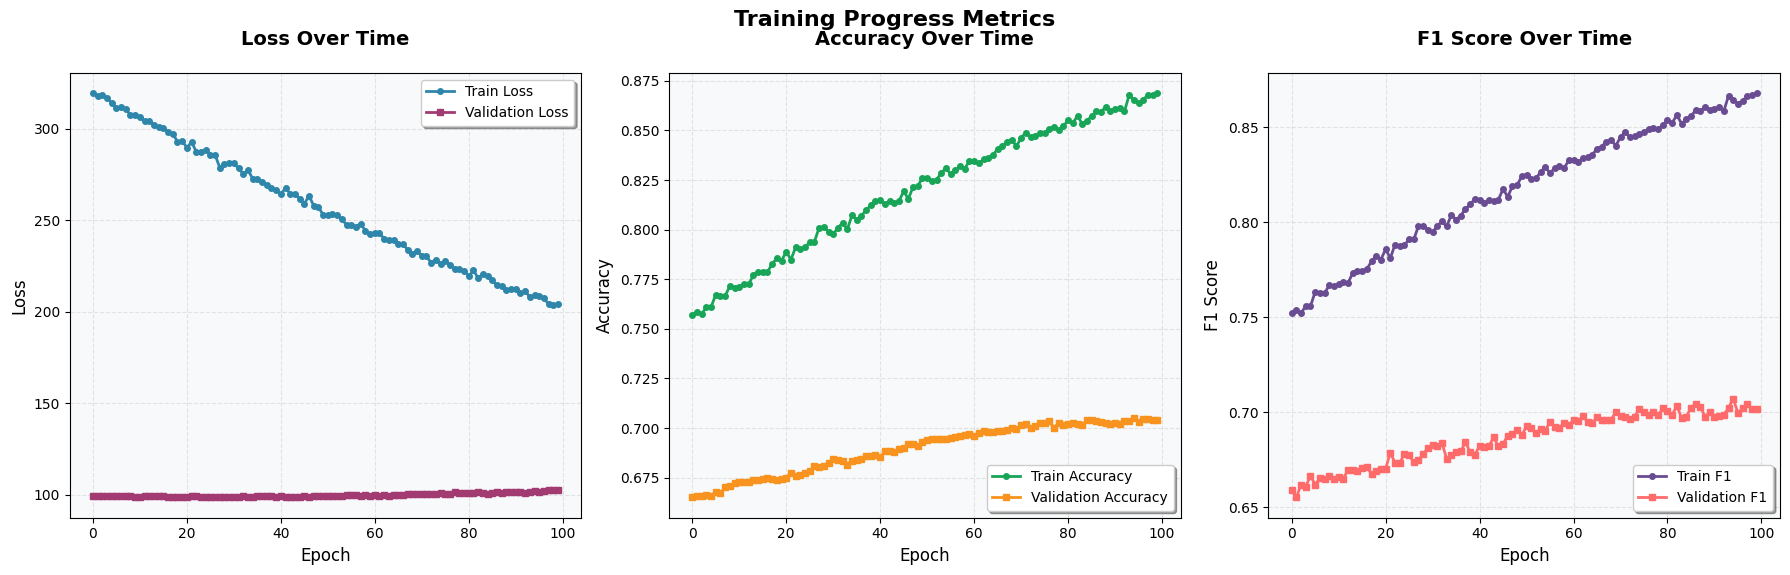

In [9]:
plot_results(history)

In [11]:

test_loss = 0.0
test_preds = []
test_labels = []

bert.eval()
for step, batch in enumerate(tqdm(dataloader.get_split('test'), total=dataloader.steps('test'))):
    logits = bert(batch['input_ids'].to(device))
    probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
    pred = torch.argmax(probs, dim=-1) # (B)
    test_preds += pred.detach().tolist()
    test_labels += [l.item() for l in batch['label_ids']]
    loss = F.cross_entropy(logits[:, 0, :].cpu(), batch['label_ids'])
    test_loss += loss.item()

print()
print(f'Test loss: {test_loss / dataloader.steps("test")}')
print(f'Test acc: {accuracy_score(test_labels, test_preds)}')
print(f'Test f1: {f1_score(test_labels, test_preds)}')

782it [00:00, 2023.46it/s]                         


Test loss: 0.6752439363169151
Test acc: 0.69492
Test f1: 0.7041160724677038


In [12]:
# Save trained model to home directory
home_dir = os.path.expanduser('~')
model_save_dir = os.path.join(home_dir, '.microbert_model')

# Prepare configuration
config = {
    'vocab_size': len(tokenizer.vocab),
    'n_layers': n_layers,
    'n_heads': n_heads,
    'max_seq_len': MAX_SEQ_LEN,
    'n_classes': 2,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'num_epochs': NUM_EPOCHS
}

# Use utility function to save model
save_model(bert, tokenizer, history, config, model_save_dir)

Model saved to: /home/wukong/.microbert_model/microbert_classification.pth
Tokenizer vocabulary saved to: /home/wukong/.microbert_model/tokenizer_vocab.json
Training history saved to: /home/wukong/.microbert_model/training_history.json
Model configuration saved to: /home/wukong/.microbert_model/model_config.json

All files saved to directory: /home/wukong/.microbert_model


In [13]:
import os
from microbert.utils import load_model, predict_sentiment

def predict():
    # Model file path
    home_dir = os.path.expanduser('~')
    model_dir = os.path.join(home_dir, '.microbert_model')
    
    # Check if model files exist
    if not os.path.exists(model_dir):
        print(f"Error: Model directory does not exist: {model_dir}")
        print("Please run train.py first to train the model")
        return
    
    # Load model
    print("Loading model...")
    model, tokenizer, config = load_model(model_dir)
    print(f"Model configuration: {config}")
    
    # Test texts
    test_texts = [
        "This movie is absolutely fantastic! I loved every minute of it.",
        "Terrible film, waste of time and money. Don't watch it.",
        "The acting was okay but the plot was confusing.",
        "Amazing performance by all actors, highly recommended!",
        "Boring and predictable, I fell asleep halfway through."
    ]
    
    print("\n=== Sentiment Analysis Results ===")
    for i, text in enumerate(test_texts, 1):
        prediction, confidence = predict_sentiment(model, tokenizer, text)
        sentiment = "Positive" if prediction == 1 else "Negative"
        print(f"{i}. Text: {text}")
        print(f"   Prediction: {sentiment} (Confidence: {confidence:.3f})")
        print()

predict()

Loading model...
Model loaded from /home/wukong/.microbert_model
Model configuration: {'vocab_size': 251641, 'n_layers': 1, 'n_heads': 1, 'max_seq_len': 128, 'n_classes': 2, 'batch_size': 32, 'learning_rate': 0.0001, 'num_epochs': 100}

=== Sentiment Analysis Results ===
1. Text: This movie is absolutely fantastic! I loved every minute of it.
   Prediction: Negative (Confidence: 0.934)

2. Text: Terrible film, waste of time and money. Don't watch it.
   Prediction: Negative (Confidence: 0.934)

3. Text: The acting was okay but the plot was confusing.
   Prediction: Negative (Confidence: 0.934)

4. Text: Amazing performance by all actors, highly recommended!
   Prediction: Negative (Confidence: 0.934)

5. Text: Boring and predictable, I fell asleep halfway through.
   Prediction: Negative (Confidence: 0.934)

